## CT Scan Simulator

In [1]:
import os
from ipywidgets import Dropdown, IntSlider, interactive_output
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np


### Image selection

In [2]:
def on_image_change(change):
    global selected_image
    selected_image = change['new']


selected_image = "Shepp_logan.jpg"

images = ["CT_ScoutView.jpg", 
          "CT_ScoutView-large.jpg", 
          "Kolo.jpg", 
          "Kropka.jpg", 
          "Kwadraty2.jpg", 
          "Paski2.jpg", 
          "SADDLE_PE.JPG", 
          "SADDLE_PE-large.JPG", 
          "Shepp_logan.jpg"]

dropdown = Dropdown(
    options=images,
    value="Shepp_logan.jpg",
    description="Obraz:"
)

dropdown.observe(on_image_change, names='value')
display(dropdown)


Dropdown(description='Obraz:', index=8, options=('CT_ScoutView.jpg', 'CT_ScoutView-large.jpg', 'Kolo.jpg', 'Kr…

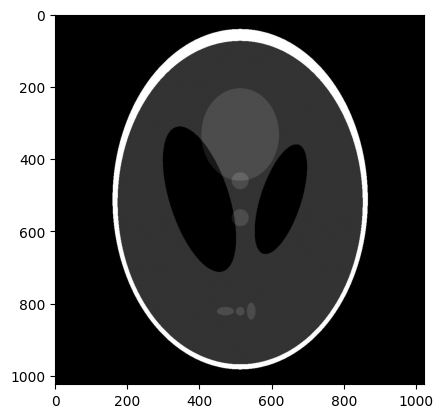

In [3]:
image_path = os.path.join("images", selected_image)

image = imread(image_path, as_gray=True)
plt.imshow(image, cmap="gray")
plt.show()


### Setting the positions of the emitters and detectors

In [4]:
def get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center):
    start_angle = alpha - angle_range / 2
    angles = np.linspace(0, angle_range, num_detectors) + start_angle

    cx, cy = center
    x = radius * np.cos(np.radians(angles)) - cx
    y = radius * np.sin(np.radians(angles)) - cy

    coordinates = np.floor(np.array(list(zip(x, y)))).astype(int)
    return coordinates

def get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center):
    start_angle = alpha - angle_range / 2 + 180
    angles = np.linspace(0, angle_range, num_detectors) + start_angle
    
    cx, cy = center
    x = radius * np.cos(np.radians(angles)) - cx
    y = radius * np.sin(np.radians(angles)) - cy

    coordinates = np.floor(np.array(list(zip(x, y)))).astype(int)
    return coordinates[::-1]


### Bresenham's algorithm

In [5]:
def bresenham_line(x0, y0, x1, y1):
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    points = []

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    x, y = x0, y0

    # Determining the direction
    if x0 > x1:
        sx = -1
    else:
        sx = 1

    if y0 > y1:
        sy = -1
    else:
        sy = 1

    if dx > dy:  # Horizontal line
        err = dx / 2.0
        while x != x1:  # Loop iterating through all points on the line
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy  # If the error is less than 0, move y
                err += dx
            x += sx  # Increase x by one step in the appropriate direction
    else:  # Vertical line
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx  # If the error is less than 0, move x
                err += dy
            y += sy  # Increase y by one step in the appropriate direction

    points.append((x, y))

    # TTransposing the array to get list of x and y coordinates
    return np.array(points).T


### Radom transform

In [6]:
# Normalizing the values in the array to the range [0, 1]
def normalize_range(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))


# Extend the matrix with zeros so that its new size fits into the circle 
def pad_image(image):
    height, width = image.shape

    size = int(np.ceil(np.sqrt(height**2 + width**2)))

    pad_y = (size - height) / 2
    pad_x = (size - width) / 2
    pad = [
        (int(np.floor(pad_y)), int(np.ceil(pad_y))),
        (int(np.floor(pad_x)), int(np.ceil(pad_x)))
    ]

    return np.pad(image, pad, mode='constant', constant_values=0)


def remove_image_pad(img, height, width):
    y, x = img.shape  # Dimensions of the input image

    start_x = x // 2 - width // 2
    start_y = y // 2 - height // 2

    return img[start_y:start_y + height, start_x:start_x + width]


def visualize_sinogram(sinogram):
    plt.clf()
    plt.imshow(np.swapaxes(sinogram, 0, 1), cmap="gray")
    plt.title("Sinogram")
    display(plt.gcf())
    clear_output(wait=True)


# Single image scan for a given angle alpha
def scan(image, alpha, angle_range, num_detectors, radius, center):
    emitters_coordinates = get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center)
    detectors_coordinates = get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center)
    
    # Determining the path for each emitter-detector pair
    lines = [np.array(bresenham_line(x1, y1, x0, y0)) for (x0, y0), (x1, y1) in zip(emitters_coordinates, detectors_coordinates)]
    
    # Calculating the sum of pixel values along each path
    projections = [np.sum(image[tuple(line)]) for line in lines]
    
    return normalize_range(projections)


def radon_transform(image, num_scans, num_detectors, angle_range, visualize=False):
    image = normalize_range(image)
    image = pad_image(image)
    image_center = np.floor(np.array(image.shape) / 2).astype(int)
    radius =image.shape[0] // 2  # Radius of the circle on which the emitters and detectors are placed

    alphas = np.linspace(0, 180, num_scans)  # List of angles for which the scans will be done
    sinogram = np.zeros((num_scans, num_detectors))
    visualization = []

    for i, alpha in enumerate(alphas):
        image_scan = scan(image, alpha, angle_range, num_detectors, radius, image_center)
        sinogram[i] = image_scan
        
        if visualize:
            visualization.append(sinogram.copy())

    if visualize:
        return sinogram, visualization
    else:
        return sinogram


In [7]:
def on_num_scans_change(change):
    global num_scans
    num_scans = change['new']


def on_num_detectors_change(change):
    global num_detectors
    num_detectors = change['new']


def on_angle_range_change(change):
    global angle_range
    angle_range = change['new']


def on_visualize_change(change):
    global visualize_scanning
    if change['new'] == "Tak":
        visualize_scanning = True
    else:
        visualize_scanning = False


num_scans = 180
num_detectors = 180
angle_range = 180
visualize_scanning = False

num_scans_widget = IntSlider(value=180, min=90, max=720, step=90, description="Liczba skanów:", disabled=False)
num_detectors_widget = IntSlider(value=180, min=90, max=720, step=90, description="Liczba detektorów:", disabled=False)
angle_range_widget = IntSlider(value=180, min=45 , max=270 , step=45 , description="Rozpiętość wachlarza:", disabled=False)
visualize_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Wizualizuj: "
)

num_scans_widget.observe(on_num_scans_change, names='value')
num_detectors_widget.observe(on_num_detectors_change, names='value')
angle_range_widget.observe(on_angle_range_change, names='value')
visualize_dropdown.observe(on_visualize_change, names='value')
display(num_scans_widget, num_detectors_widget, angle_range_widget, visualize_dropdown)


IntSlider(value=180, description='Liczba skanów:', max=720, min=90, step=90)

IntSlider(value=180, description='Liczba detektorów:', max=720, min=90, step=90)

IntSlider(value=180, description='Rozpiętość wachlarza:', max=270, min=45, step=45)

Dropdown(description='Wizualizuj: ', index=1, options=('Tak', 'Nie'), value='Nie')

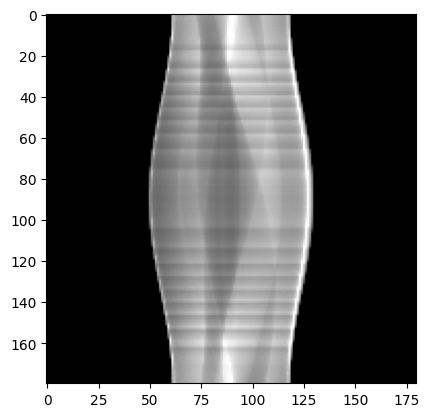

In [8]:
def plot_visualization(index):
    index = min(index, len(visualization) - 1)
    plt.imshow(visualization[index], cmap='gray')
    plt.axis('off')
    plt.show()
    

if visualize_scanning:
    sinogram, visualization = radon_transform(image, num_scans, num_detectors, angle_range, visualize=visualize_scanning)
    index_slider = IntSlider(value=1, min=1, max=len(sinogram), step=1, description="Postęp obrotu:")
    ui = interactive_output(plot_visualization, {'index': index_slider})
    display(index_slider, ui)
else:
    sinogram = radon_transform(image, num_scans, num_detectors, angle_range, visualize=visualize_scanning)
    plt.imshow(sinogram, cmap="gray")

### Sinogram filtering

### Inverse Radon transform

In [9]:
def reconstruct_image(image, scan_count, scan, alpha, angle_range, num_detectors, radius=1, center=(1,1)):
    emitters_coordinates = get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center)
    detectors_coordinates = get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center)
    
    # Determining the path for each emitter-detector pair
    lines = [np.array(bresenham_line(x1, y1, x0, y0)) for (x0, y0), (x1, y1) in zip(emitters_coordinates, detectors_coordinates)]
    
    # Increasing the pixel value along the radiation path and the scan counter
    for i, line in enumerate(lines):
        image[tuple(line)] += scan[i]
        scan_count[tuple(line)] += 1

    return image, scan_count

def inverse_radon_transform(image_shape, sinogram, angle_range, filtering=False, visualize=False):
    num_scans, num_detectors = sinogram.shape
    
    image_reconstructed = pad_image(np.zeros(image_shape))
    scan_count = np.zeros(image_reconstructed.shape)

    image_center = np.floor(np.array(image_reconstructed.shape) / 2).astype(int)
    radius = image_reconstructed.shape[0] // 2
    alphas = np.linspace(0, 180, num_scans)

    if filtering:
        pass

    visualization_inverse = []
    
    for i, alpha in enumerate(alphas):
        image_reconstructed, scan_count = reconstruct_image(
            image_reconstructed,
            scan_count,
            sinogram[i],
            alpha, 
            angle_range,
            num_detectors,
            radius,
            image_center
        )

        if visualize:
            image_reconstructed_no_pad = remove_image_pad(image_reconstructed / np.maximum(scan_count, 1), *image_shape)
            visualization_inverse.append(image_reconstructed_no_pad.copy())

    scan_count[scan_count == 0] = 1  # Zero division preotection
    image_reconstructed /= scan_count  # Dividing by the scan count
    image_reconstructed = normalize_range(image_reconstructed)  # Normalizing to the range [0, 1]
    image_reconstructed = remove_image_pad(image_reconstructed, *image_shape)   # Removing padding

    if visualize:
        return image_reconstructed, visualization_inverse
    else:
        return image_reconstructed


In [10]:
def on_visualize_change(change):
    global visualize_inverse
    if change['new'] == "Tak":
        visualize_inverse = True
    else:
        visualize_inverse = False


def on_filter_change(change):
    global filter_sinogram
    if change['new'] == "Tak":
        filter_sinogram = True
    else:
        filter_sinogram = False


visualize_inverse = False
filter_sinogram = False

filter_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Filtruj sinogram: "
)
visualize_inverse_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Wizualizuj: "
)

filter_dropdown.observe(on_filter_change, names='value')
visualize_inverse_dropdown.observe(on_visualize_change, names='value')
display(filter_dropdown, visualize_inverse_dropdown)


Dropdown(description='Filtruj sinogram: ', index=1, options=('Tak', 'Nie'), value='Nie')

Dropdown(description='Wizualizuj: ', index=1, options=('Tak', 'Nie'), value='Nie')

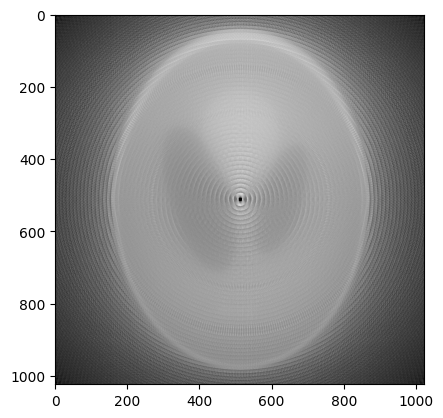

In [11]:
def plot_inverse_visualization(index):
    index = min(index, len(visualization_inverse) - 1)
    plt.imshow(visualization_inverse[index], cmap='gray')
    plt.axis('off')
    plt.show()

if visualize_inverse:
    reconstructed_image, visualization_inverse = inverse_radon_transform(image.shape, sinogram, angle_range, filtering=filter_sinogram, visualize=visualize_inverse)
    index_slider = IntSlider(value=1, min=1, max=len(visualization_inverse), step=1, description="Postęp obrotu:")
    ui = interactive_output(plot_inverse_visualization, {'index': index_slider})
    display(index_slider, ui)
else:
    reconstructed_image = inverse_radon_transform(image.shape, sinogram, angle_range, filtering=filter_sinogram, visualize=visualize_inverse)
    plt.imshow(reconstructed_image, cmap="gray")